Here visuzilation of cosine similarity distribution is performed.

In [1]:
import numpy as np
import torch
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from face_lib.dataset_classes.lightning_datasets import MXFaceDataset
from face_lib.models.scf import SoftmaxWeights

In [2]:
ms1m_data = np.load("/app/cache/features/ms1m_emb.npz")
labels = np.load("/app/datasets/ms1m/labels.npy")

In [3]:
radius = 64
features = torch.tensor(ms1m_data["embs"], dtype=torch.float32)
softmax_weights = SoftmaxWeights(
    softmax_weights_path="/app/model_weights/backbone/ms1mv3_arcface_r50/softmax_weight.pt",
    radius=radius,
).softmax_weights
wc = softmax_weights[labels, :]
cosine_sim = torch.sum(features * wc, dim=1, keepdim=True) / radius
cosine_sim = cosine_sim[:, 0].numpy()

In [5]:
np.save("/app/model_weights/ms1m_cache/cosine_sim.npy", cosine_sim)

### Uniform sampling

In [6]:
batch_size = 500
rng = np.random.default_rng(776)

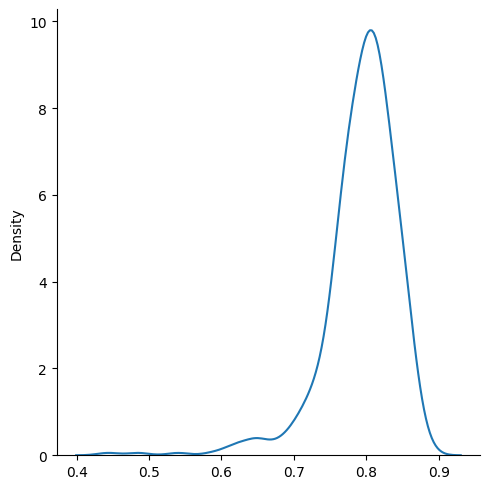

In [7]:
batch_ids = rng.choice(np.arange(features.shape[0]), batch_size)
batch_cosine = cosine_sim[batch_ids]
sns.displot(
    batch_cosine,
    kind="kde",
    log_scale=False,
    common_norm=False,
)

<AxesSubplot:ylabel='Count'>

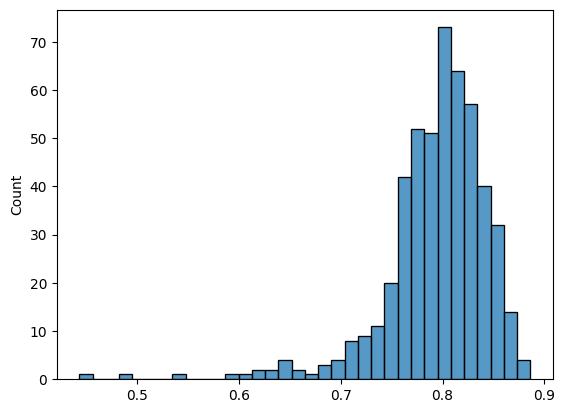

In [8]:
sns.histplot(
    batch_cosine,
    # kind="kde",
    log_scale=False,
    common_norm=False,
)

In [9]:
sorted_id_map = np.argsort(cosine_sim)

sorted_cosine_sim = np.sort(cosine_sim)
coarseness = 300
derivative_cosine_sim = np.gradient(sorted_cosine_sim[::coarseness])

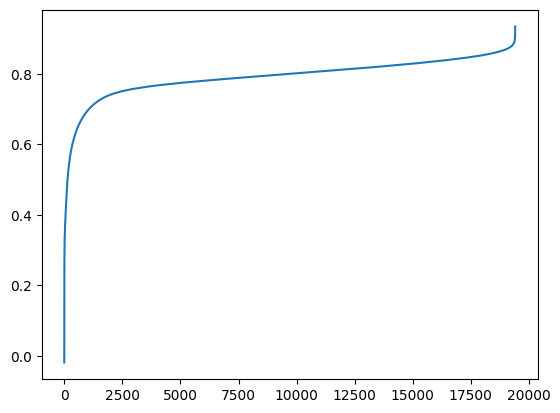

In [10]:
plt.plot(sorted_cosine_sim[::coarseness])

In [13]:
sorted_id_scores.shape[0]

5822653

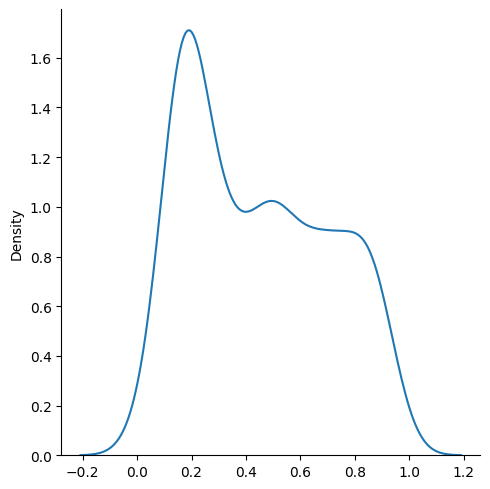

In [11]:
sorted_id_scores = np.array(
    [derivative_cosine_sim[i // coarseness] for i in range(len(sorted_id_map))]
)
sorted_batch_ids = rng.choice(
    np.arange(features.shape[0]),
    batch_size,
    p=sorted_id_scores / np.sum(sorted_id_scores),
)
uniform_batch_ids = sorted_id_map[sorted_batch_ids]
uniform_batch_cosine = cosine_sim[uniform_batch_ids]
sns.displot(
    uniform_batch_cosine,
    kind="kde",
    log_scale=False,
    common_norm=False,
)

<AxesSubplot:ylabel='Count'>

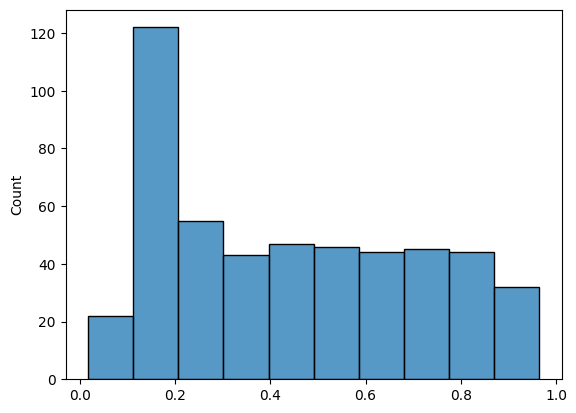

In [12]:
sns.histplot(
    uniform_batch_cosine,
    # kind="kde",
    log_scale=False,
    common_norm=False,
)

In [85]:
np.mean(uniform_batch_cosine), np.std(uniform_batch_cosine)

(0.47663954, 0.28454176)

107.60991

In [76]:
derivative_cosine_sim.min()

1.2218952e-06

In [39]:
np.mean(cosine_sim), np.std(cosine_sim), np.median(cosine_sim)

(0.7914734, 0.060435936, 0.79981095)

Text(0.5, 9.444444444444438, 'Cosine Sim')

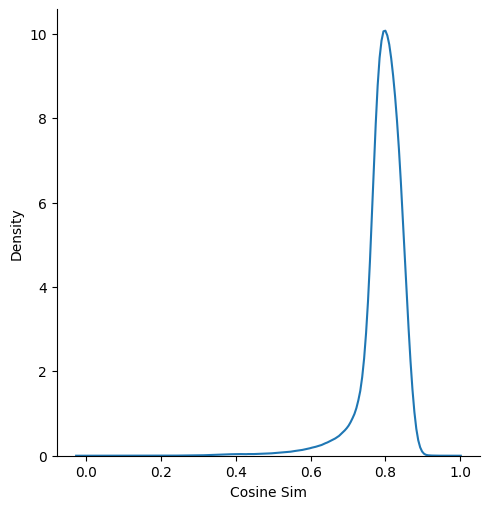

In [35]:
sns.displot(
    cosine_sim,
    kind="kde",
    # x="Cosine Sim",
    # hue="Error Kind",
    log_scale=False,
    common_norm=False,
)
plt.xlabel(f"Cosine Sim")
# plt.savefig(out_name, dpi=300)

/home/erlygin/miniconda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

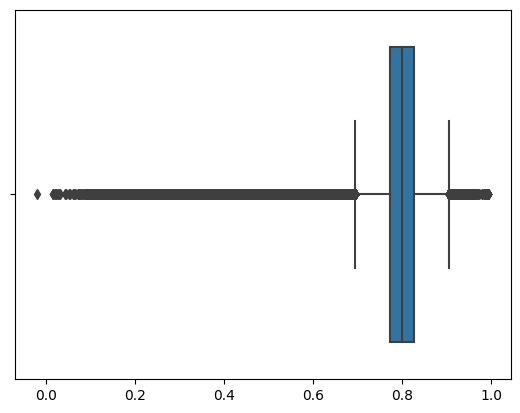

In [40]:
sns.boxplot(cosine_sim)

In [26]:
cos_theta.shape

torch.Size([5822653, 1])

In [14]:
np.linalg.norm(features[0])

1.0

In [4]:
labels.shape

(5822653,)

In [5]:
labels

array([    0,     0,     0, ..., 85741, 85741, 85741])

In [6]:
ms1m_data["embs"].shape

(5822653, 512)

In [8]:
ms1m_data["unc"]

array([[7.1087084],
       [7.3318734],
       [7.234938 ],
       ...,
       [7.556389 ],
       [7.081358 ],
       [6.981141 ]], dtype=float32)